In [37]:
######### MODULES ##########
import sys, os, re
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy import interpolate as spinter, optimize as spopt
from delta_method import delta_method, parametric_bootstrap
plt.rcParams.update({'font.size':14, "xtick.direction":"in", "ytick.direction":"in"})
#np.set_printoptions(threshold=sys.maxsize)
#pd.set_option('display.max_rows', 500)

pyro_channels = ["Ch1","Ch2","Ch3","Ch4"] # Establishing a catagory of diagnostics will be helpful later.

In [38]:
###########SHINY NEW FUNCTIONS###############

def polynomial(x, *coeffs):
    x = np.array(x)
    y = np.sum([coeff*x**n for n, coeff in enumerate(coeffs)], axis= 0)
    return y

def reciplical_polynomial(x, *coeffs):
    x = np.array(x)
    y = np.sum([coeff*(x+coeffs[0])**-n if n != 0 else np.zeros_like(x) for n, coeff in enumerate(coeffs)], axis= 0)
    return y

def gradient(x, m):
    x = np.array(x)
    return m*x +1

def flatten_list(bookshelf): # Will fail to flatten objects that are iterable but not subscriptable. eg. dict_values
    papers= []
    for book in bookshelf:
        if type(book) == str: #strings are iterable but should not be flattened
            papers.append(book)
            continue
        try:
            book[0]
        except: #This is not a list! Add this item to the papers. #Also why does numpy throw an IndexError whereas python throws a TypeError?!?
            papers.append(book)
        else:
            papers += flatten_list(book) #This is a list! Its items must be seperated first, then it can be added to the papers.
    return papers

def transform_list(matrix):
    return [*zip(*matrix)] #IDK how this works. Ross did it for me.

def roll_average(xs, ys, number_of_points= 100, window_width=1):
    xs = flatten_list(xs)
    ys = flatten_list(ys)

    points = np.linspace(np.nanmin(xs), np.nanmax(xs), number_of_points)
    average = []
    uncertainty = []
    
    for point in points:
        points_in_window = [ys[n] for n, x in enumerate(xs) if x-window_width < point and point < x+window_width] #create a list of points inside the window
        average = average + [np.nanmean(points_in_window)]
        uncertainty = uncertainty + [np.nanstd(points_in_window)]

    return points, average, uncertainty

def polynomial_fit(xs, ys, number_of_points= 100, x0= [0, 0], constraints= None, confidence= 0.1, reciplical= False, silent= False):
    xs, ys = flatten_list(xs), flatten_list(ys)
    is_valid = np.logical_and(~np.isnan(xs), ~np.isnan(ys))
    xs, ys = np.array(xs)[is_valid], np.array(ys)[is_valid] #remove nans

    model_function = gradient #reciplical_polynomial if reciplical else polynomial
    if constraints == None: constraints = [np.full_like(x0, -np.inf, dtype= float), np.full_like(x0, +np.inf, dtype= float)]
    bounds = spopt.Bounds(*constraints)

    points = np.linspace(np.nanmin(xs), np.nanmax(xs), number_of_points)

    popt, pcov = spopt.curve_fit(model_function, xs, ys, p0= x0, bounds= bounds, nan_policy= "omit", method= "trf", loss= "cauchy") # loss = "linear" for least squares. "huber" "soft_l1" "cauchy" "arctan"
    delta = delta_method(pcov, popt, points, model_function, xs, ys, confidence)

    poly_fit = model_function(points, *popt)

    if not silent:
        print("Optimal coeffients:")
        print(*popt)

    return points, poly_fit, delta

def read_metadata(requested_data): #DO NOT OPEN MULTIPLE SHEETS AT ONCE. OPEN THE SHOT SHEET AND TARGET SHEET SEPERATELY!
    shot_list = ["SHOT #","Date","Time","Purpose","Target X","Target Y","Target Z","Wheel XPS","position on wheel","TARGET NUMBER","Laser Energy (before comp) [J]","Laser duration [fs]","Horiz ns/div","Trigger val [mV]","C1 [V/div]","C2 [V/div]","C3 [V/div]","C4 [V/div]","C1 att [dB]","C2 att [dB]","C3 att [dB]","C1 diag","C2 diag","C3 diag","C4 diag","Comments JLD scope","THz comments","Column2","X-ray comments","Column3","Column4","Column5"]
    target_list = ["Date","Number","Position in the box","Wheel","Position on the wheel","Rotation angle(TARGET)","XYZ (TARGET)","Thickness (um)","Length(mm)","Material","Type","Comments"]

    if requested_data[0] in shot_list : sheet, header_row = "Shot-list", 1 # weird python syntax
    if requested_data[0] in target_list : sheet, header_row = "Target list", 0

    dataframe = pd.read_excel(io= "organised_data\\Shots_Targets_Diagnostics.xlsx", # numpy is bad at reading excel files.
                              sheet_name= sheet,
                              header= header_row,
                              usecols= requested_data)
    
    dictionary = dataframe.to_dict(orient= "list")
    return dictionary

def open_pyro_oscilloscope(requested_data, shots, file_directories, file_names, silent= False):
    channel = "Ch1" if requested_data == "pyro_time" else requested_data
    regex_code = ".*SHOT("+'|'.join(shots)+")[^0-9]*[0-9]{3}[^0-9].*"+channel+".csv"
    match = [bool(re.findall(regex_code, file_name)) for file_name in file_names]
    filtered_file_directories = file_directories[match]
    filtered_file_names = file_names[match]
    number_of_files = len(filtered_file_names)
    filtered_file_paths = [os.path.join(filtered_file_directories[n],filtered_file_names[n]) for n in range(number_of_files)]
                            
    shot_no = [int(re.search(regex_code, filtered_file_name).group(1)) for filtered_file_name in filtered_file_names]
    pyro_data = [np.genfromtxt(filtered_file_path, delimiter=',', skip_header =0, usecols= 3 if requested_data == "pyro_time" else 4) for filtered_file_path in filtered_file_paths]

    if not silent: # remember to do silent == True if you use read_data in a loop
        print("Found {:d} files:".format(len(filtered_file_names)))
        [print("   " + filtered_file_name) for filtered_file_name in filtered_file_names]

    return shot_no, pyro_data

def autocrop(array, noise_level= 10, silent= True): #crops to rectangular section with many large values.
    row_s2n = np.std(array, axis= 1) # Try different ways of estimating the S2N
    row_threshold = np.percentile(row_s2n, noise_level)
    column_s2n = np.std(array, axis= 0)
    column_threshold = np.percentile(column_s2n, noise_level)
    first_row, last_row = int(np.argwhere(row_s2n > row_threshold)[0]), int(np.argwhere(row_s2n > row_threshold)[-1])
    first_column, last_column = int(np.argwhere(column_s2n > column_threshold)[0]), int(np.argwhere(column_s2n > column_threshold)[-1])

    if not silent:
        fig, axs = plt.subplots()
        axs.plot(row_s2n, color= "tab:blue")
        axs.plot(column_s2n, color= "tab:orange")
        axs.hlines([row_s2n, column_s2n], colors= ["tab:blue","tab:orange"], xmin= 0, xmax= 1, transform=axs.get_yaxis_transform())
        plt.show()

    return array[first_row:last_row, first_column:last_column]

def dead_pixel_filter(image, dead_pixels =1):
    # Remove the most anomalous 1% of pixels and replace with nearest neighbour.
    upper_percentile = 100 - dead_pixels/2
    lower_percentile = dead_pixels/2
    notdead = np.logical_and(image <= np.percentile(image,upper_percentile), image >= np.percentile(image,lower_percentile) )
    coords = np.mgrid[0:image.shape[0], 0:image.shape[1]]
    coords = np.moveaxis(coords, 0, -1) #refromat the array such that we have pairs of coordinates. ie. [[0,0],[0,1],[0,2]] ect.
    nearest = spinter.NearestNDInterpolator(coords[notdead], image[notdead])
    image = nearest(coords[:,:,0],coords[:,:,1])

    return image

def filter_files(file_directories, file_names, regex_code):
    match = [bool(re.findall(regex_code, file_name)) for file_name in file_names]
    filtered_file_directories = file_directories[match]
    filtered_file_names = file_names[match]
    number_of_files = len(filtered_file_names)
    filtered_file_paths = [os.path.join(filtered_file_directories[n],filtered_file_names[n]) for n in range(number_of_files)]

    return filtered_file_paths, filtered_file_directories, filtered_file_names

def open_pyro_oscilloscope(requested_data, shots, file_directories, file_names, function= lambda x:x, silent= False):
    channel = "Ch1" if requested_data == "pyro_time" else requested_data
    regex_code = ".*SHOT("+'|'.join(shots)+")[^0-9]*[0-9]{3}[^0-9].*"+channel+".csv"
    filtered_file_paths, _, filtered_file_names = filter_files(file_directories, file_names, regex_code)
                            
    shot_no = [int(re.search(regex_code, filtered_file_name).group(1)) for filtered_file_name in filtered_file_names]
    pyro_data = [function(np.genfromtxt(filtered_file_path, delimiter=',', skip_header =0, usecols= 3 if requested_data == "pyro_time" else 4))
                 for filtered_file_path in filtered_file_paths]

    if not silent: # remember to do silent == True if you use read_data in a loop
        print("Found {:d} files:".format(len(filtered_file_names)))
        [print("   " + filtered_file_name) for filtered_file_name in filtered_file_names]

    return shot_no, pyro_data

def open_emp_oscilloscope(requested_data, shots, file_directories, file_names, function= lambda x:x, silent= False):
    emp_oscilloscope = ["time","bdot","tof","diode"]
    column = emp_oscilloscope.index(requested_data)
    regex_code = "(?i)s0*("+'|'.join(shots)+")[^0-9]*\.csv"
    filtered_file_paths, _, filtered_file_names = filter_files(file_directories, file_names, regex_code)

    shot_no = [int(re.search(regex_code, filtered_file_name).group(1)) for filtered_file_name in filtered_file_names]
    emp_data = [function(np.genfromtxt(filtered_file_path, delimiter=',', skip_header =18, usecols= column))
                for filtered_file_path in filtered_file_paths]

    if not silent: # remember to do silent == True if you use read_data in a loop
        print("Found {:d} files:".format(len(filtered_file_names)))
        [print("   " + filtered_file_name) for filtered_file_name in filtered_file_names]

    return shot_no, emp_data

def open_xray_photos(requested_data, shots, file_directories, file_names, function= lambda x:x, silent= False):
    raw = "-raw" if requested_data == "xray_raw" else ""
    regex_code = ".*[0-9]{2}" +raw+ " SHOT(" +'|'.join(shots)+ ").tif"
    filtered_file_paths, _, filtered_file_names = filter_files(file_directories, file_names, regex_code)

    shot_no = [int(re.search(regex_code, filtered_file_name).group(1)) for filtered_file_name in filtered_file_names]
    data = [function(np.array(Image.open(filtered_file_path))) for filtered_file_path in filtered_file_paths]

    if not silent: # remember to do silent == True if you use read_data in a loop
        print("Found {:d} files:".format(len(filtered_file_names)))
        [print("   " + filtered_file_name) for filtered_file_name in filtered_file_names]

    return shot_no, data


def read_diagnostic_data(requested_data, function= lambda x:x , silent= False): #Currently supports the xray cam, pyro oscilloscope and the emp oscilloscope. Doesn't support target photos, espec, focal spot cam and pyrocams. 
    data_path = "organised_data\\"
    dictionary = {"shot":[]}
    emp_oscilloscope = ["time","bdot","tof","diode"]
    pyro_oscilloscope = ["Ch1","Ch2","Ch3","Ch4","pyro_time"]
    xray_cam = ["xray", "xray_raw"]

    all_file_directories = [root for root, dirs, files in os.walk(data_path) for file in files]
    all_file_directories = np.array(all_file_directories)
    all_file_names = [file for root, dirs, files in os.walk(data_path) for file in files]
    all_file_names = np.array(all_file_names)
    requested_data = {ch: [str(int(shot)) for shot in shots] for ch, shots in requested_data.items()} # ensure that all shot numbers are strings of ints. floats will screw up regex.

    for request, shots in requested_data.items():
        if request in pyro_oscilloscope:
            new_shots, new_data = open_pyro_oscilloscope(request, shots, all_file_directories, all_file_names, function= function, silent= silent)
        elif request in emp_oscilloscope:
            new_shots, new_data = open_emp_oscilloscope(request, shots, all_file_directories, all_file_names, function= function, silent= silent)
        elif request in xray_cam:
            new_shots, new_data = open_xray_photos(request, shots, all_file_directories, all_file_names, function= function, silent= silent)
        else:
            new_shots, new_data = [], []
            print("WARNING!! {0} is not a recognised data type.".format(request))

        old_shots = dictionary["shot"]
        union_shots = np.unique(old_shots + new_shots).tolist()

        dictionary = {diagnostic: [readings[old_shots.index(shot)] if shot in old_shots else np.nan for shot in union_shots] for diagnostic, readings in dictionary.items()} #rearrange the existing data to corrispond with its respective shot
        dictionary[request] = [new_data[new_shots.index(shot)] if shot in new_shots else np.nan for shot in union_shots] # Add the new data to it's respective shot.
        dictionary["shot"] = union_shots #add the new shots

    return dictionary

In [39]:
shotsheet = read_metadata(["SHOT #","Target X","Target Z","TARGET NUMBER","Laser Energy (before comp) [J]"])
targetsheet = read_metadata(["Number","Wheel"])

for key in shotsheet.keys():
    shotsheet[key] = [np.nan if re.search('[^\d.]', str(value)) else float(value) for value in shotsheet[key]] # Filter out all numberic characters. Numeric characters being: `0123456789.`

row_has_data = ~np.all(np.isnan(transform_list(shotsheet.values())), axis = 1)
shotsheet = {key: [cell for cell, cell_has_data in transform_list((column, row_has_data)) if cell_has_data] for key, column in shotsheet.items()} # Filter out any rows that don't have any entries. (all nan rows)

shotsheet["Wheel"] = [targetsheet["Wheel"][targetsheet["Number"].index(target_number)] if target_number in targetsheet["Number"] else np.nan for target_number in shotsheet["TARGET NUMBER"]] # give each target it's respective wheel.
shotsheet["SHOT #"] = [int(shot) for shot in shotsheet["SHOT #"]] #make all shots into intergers. Will fail if there is a nan value.



In [40]:
###Initialisation
target = 0
shotsheet["relative X"] = np.full(len(shotsheet["SHOT #"]), fill_value= np.nan)
shotsheet["relative Z"] = np.full(len(shotsheet["SHOT #"]), fill_value= np.nan)
###Loop over all shots
for shot in shotsheet["SHOT #"]:
    s = shotsheet["SHOT #"].index(shot) #find the corrisponding index for this shot. Should be shot -1 = s.
    if shotsheet["TARGET NUMBER"][s] != target:
        delta_x = shotsheet["Target X"][s]
        delta_z = shotsheet["Target Z"][s]
        target = shotsheet["TARGET NUMBER"][s] # ASSUMES THAT WE DON'T RETURN BACK TO THE SAME TARGET.

    shotsheet["relative X"][s] = shotsheet["Target X"][s] -delta_x #make the target movement in x relitive to the first shot
    shotsheet["relative Z"][s] = shotsheet["Target Z"][s] -delta_z #make the target movement in z relitive to the first shot

shotsheet["d"] = np.linalg.norm([shotsheet["relative X"], shotsheet["relative Z"]], axis= 0) # pythagorus to find d. This might be a little simplistic since we know the angle should be 25°

### Choose which targets and channels to use here!

`targets` is a dictionary with the pyroelectric channels and corrisponding target numbers. These targets will be analysised and plotted (if the relevant .csv data file exists). For example,
```
targets = {"Ch2": [105,106],
           "Ch3": [66,67,69,90,105,106],
           "Ch4": [66,67,69,86]}
```

`emp` is a dictionary with the pyroelectric emp channels and corrisponding target numbers. This will be used for background subtraction. Every target in `targets` must also appear here. For example,
```
emp = {"Ch1": [90,105,106],
       "Ch2": [66,67,69,81,86]}
```

`oscilloscope` is very simular to `targets` except it will not be background subtracted. It will be plotted as the bdot data. Every target in `targets` should also appear here. For example,
```
oscilloscope = {"bdot": [66,67,69,86,90,105,106]}
```

In [41]:
pyro_background = {"Ch1": [90,105,106,108],
                   "Ch2": [66,67,69,81,86]}

diagnostics = {"Ch2": [105,106],
               "Ch3": [66,67,69,90,105,106],
               "Ch4": [66,67,69,86],
               "bdot": [66,67,69,86,90,105,106]}

background_lookup = {t: ch for ch, target in pyro_background.items() for t in target} #Create a target -> channel lookup table.
background_lookup = {shot: ch for shot, s in enumerate(shotsheet["SHOT #"]) for t, ch in background_lookup.items() if shotsheet["TARGET NUMBER"][s] == t} #Convert to a shot -> channel lookup table.
pyro_background_shots = {ch: [shot for t in target for shot, s in enumerate(shotsheet["SHOT #"]) if shotsheet["TARGET NUMBER"][s] == t] for ch, target in pyro_background.items()} #find the respective shots for these targets. Include both pyro emp and osc emp data mearly to ensure that has the same indexes as the next dictionary
diagnostics_shots = {ch: [shot for t in target for shot, s in enumerate(shotsheet["SHOT #"]) if shotsheet["TARGET NUMBER"][s] == t] for ch, target in diagnostics.items()} #find the respective shots for these targets. Include both the target and emp data

background_data = read_diagnostic_data(pyro_background_shots, silent= True)
diagnostic_data = read_diagnostic_data(diagnostics_shots, silent= True)

### Background subtraction
Comment this out to remove background subtraction. The bdot is exempt from background subtraction because it is not in `targets`. 

In [42]:
active_pyro_channels = np.intersect1d(pyro_channels, list(diagnostic_data.keys()))
for ch in active_pyro_channels:
    for shot in shotsheet["SHOT #"]:
        try:
            diagnostic_data[ch][diagnostic_data["shot"].index(shot)] = np.subtract(diagnostic_data[ch][diagnostic_data["shot"].index(shot)], background_data[background_lookup[shot]][background_data["shot"].index(shot)])
        except ValueError:
            continue
        # A KeyError indercates that background for that shot is unknown. Check that all targets have corrisponding background channels in `pyro_background` 

### Import Jean-luc's energy calculations seperately

In [43]:
jean_lucs = pd.read_table("jean-lucs_emp_calculations.txt",
                          encoding= "utf_8",
                          encoding_errors= "ignore", # I don't know which encoding to use for '¡' so I will ignore it for now.
                          header= 0,
                          names= ["shot", "energy"],
                          dtype= {"shot": int,
                                  "energy": float},
                          decimal= ",") # continental format
jean_lucs = jean_lucs.to_dict(orient= "list")

### Calculate minima of every channel
The diagnostic data within `pyro` also gets merged with the metadata within `shotsheet`.

In [44]:
for key in diagnostic_data.keys():
    if key == "shot": #don't add another shot number to the shotsheet.
        continue 

    if key in pyro_channels:
        diagnostic_data[key] = [np.abs(np.nanmin(reading)) for reading in diagnostic_data[key]] #find the minima of every pyro channel
    elif key == "bdot":
        diagnostic_data[key] = [np.ptp(shot) for shot in diagnostic_data[key]] #find the range of every bdot

    shotsheet[key] = [diagnostic_data[key][diagnostic_data["shot"].index(shot)] if shot in diagnostic_data["shot"] else np.nan for shot in shotsheet["SHOT #"]] #add diagnostics to the shotsheet on respective shot numbers

for key in jean_lucs.keys():
    if key != "shot":
        shotsheet[key] = [jean_lucs[key][jean_lucs["shot"].index(shot)] if shot in jean_lucs["shot"] else np.nan for shot in shotsheet["SHOT #"]] #add energy to the shotsheet on respective shot numbers

C:\Users\syf83691\AppData\Local\Temp\ipykernel_19664\3772538743.py:6: RuntimeWarning: All-NaN slice encountered
  diagnostic_data[key] = [np.abs(np.nanmin(reading)) for reading in diagnostic_data[key]] #find the minima of every pyro channel
C:\Users\syf83691\AppData\Local\Temp\ipykernel_19664\3772538743.py:6: RuntimeWarning: All-NaN axis encountered
  diagnostic_data[key] = [np.abs(np.nanmin(reading)) for reading in diagnostic_data[key]] #find the minima of every pyro channel


In [45]:
shotsheet

{'SHOT #': [1,
  2,
  3,
  4,
  5,
  6,
  7,
  8,
  9,
  10,
  11,
  12,
  13,
  14,
  15,
  16,
  17,
  18,
  19,
  20,
  21,
  22,
  23,
  24,
  25,
  26,
  27,
  28,
  29,
  30,
  31,
  32,
  33,
  34,
  35,
  36,
  37,
  38,
  39,
  40,
  41,
  42,
  43,
  43,
  44,
  45,
  46,
  47,
  48,
  49,
  50,
  51,
  52,
  53,
  54,
  55,
  56,
  57,
  58,
  59,
  60,
  61,
  62,
  63,
  64,
  65,
  66,
  67,
  68,
  69,
  70,
  71,
  72,
  73,
  74,
  75,
  76,
  77,
  78,
  79,
  80,
  81,
  82,
  83,
  84,
  85,
  86,
  87,
  88,
  89,
  90,
  91,
  92,
  93,
  94,
  95,
  96,
  97,
  98,
  99,
  100,
  101,
  102,
  103,
  104,
  105,
  106,
  107,
  108,
  109,
  110,
  111,
  112,
  113,
  114,
  115,
  116,
  117,
  118,
  119,
  120,
  121,
  122,
  123,
  124,
  125,
  126,
  127,
  128,
  129,
  130,
  131,
  132,
  133,
  134,
  135,
  136,
  137,
  138,
  139,
  140,
  141,
  142,
  143,
  144,
  145,
  146,
  147,
  148,
  149,
  150,
  151,
  152,
  153,
  154,
  155,
  156,


### Reorganise data by target
The reorganised data is saved in a new dictionary called `dataset`.

In [46]:
### initialise
dataset = {}
dataset["d"] = [[shotsheet["d"][s] for s, shot in enumerate(shotsheet["SHOT #"]) if shotsheet["TARGET NUMBER"][s] == target] for target in np.unique(shotsheet["TARGET NUMBER"])] # displacement must also be initialised because it determines which data sets are valid

### loop over all other data sets
for key in shotsheet.keys():
    if key != "d":
        dataset[key] = [[shotsheet[key][s] for s, shot in enumerate(shotsheet["SHOT #"]) if shotsheet["TARGET NUMBER"][s] == target] for target in np.unique(shotsheet["TARGET NUMBER"])] #change shape so that shots on the same target are grouped together
        dataset[key] = [target for t, target in enumerate(dataset[key]) if len(dataset["d"][t]) > 0] #filter out targets with no displacement data. (targets that were never shot)
    if key in ["TARGET NUMBER","Wheel"]:
        dataset[key] = [target[0] for target in dataset[key]] #these do not change when the target number is constant. Remove list.

### finalise
dataset["d"] = [target for target in dataset["d"] if len(target) > 0]

In [47]:
dataset

{'d': [[nan, nan, nan, nan, nan, nan, nan],
  [nan, nan, nan],
  [nan, nan, nan, nan],
  [nan, nan, nan, nan],
  [nan, nan],
  [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, 0.0],
  [0.0,
   1.0999999999999996,
   0.04999999999999982,
   0.09999999999999964,
   0.04999999999999982,
   0.0,
   0.025000000000000355,
   0.01499999999999968,
   nan,
   0.0,
   0.01499999999999968,
   0.01499999999999968,
   0.0,
   0.025000000000000355,
   0.025000000000000355,
   0.0,
   0.0],
  [0.0],
  [0.0],
  [0.0],
  [0.0],
  [0.0],
  [0.0, 0.054999999999999716],
  [0.0,
   0.019999999999999574,
   0.02000000000000135,
   0.019999999999999574,
   0.03999999999999915,
   0.0,
   0.049999999999998934,
   0.019999999999999574,
   0.47000000000000064],
  [0.0],
  [0.0, 0.4382921400162215],
  [0.0,
   0.6364157446198201,
   1.1599999999999997,
   1.696496389621858,
   2.2671568097509267,
   2.586426105652353],
  [0.0,
   0.2504495957273641,
   0.449221548904324,
   0.7147027354082254,
 

In [48]:
dataset.keys()

dict_keys(['d', 'SHOT #', 'Target X', 'Target Z', 'TARGET NUMBER', 'Laser Energy (before comp) [J]', 'Wheel', 'relative X', 'relative Z', 'Ch2', 'Ch3', 'Ch4', 'bdot', 'energy'])

### Normalisation
Comment out line 3 to stop energy normalisation. Comment out line 4 to stop normalisation to the first shot on the target.

In [49]:
### loop over all channels
for ch in {**diagnostics, **{"energy": 0}}.keys(): #loop over all diagnostic data
    dataset[ch] = [np.array(target)/np.array(dataset["Laser Energy (before comp) [J]"][n]) for n, target in enumerate(dataset[ch])] #normalise all channels for laser energy
    dataset[ch] = [np.array(target)/target[0] if ~np.isnan(target[0]) else np.array(target) for target in dataset[ch]] #normalise all channels such that they start on 1 (or np.nan).

In [50]:
dataset

{'d': [[nan, nan, nan, nan, nan, nan, nan],
  [nan, nan, nan],
  [nan, nan, nan, nan],
  [nan, nan, nan, nan],
  [nan, nan],
  [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, 0.0],
  [0.0,
   1.0999999999999996,
   0.04999999999999982,
   0.09999999999999964,
   0.04999999999999982,
   0.0,
   0.025000000000000355,
   0.01499999999999968,
   nan,
   0.0,
   0.01499999999999968,
   0.01499999999999968,
   0.0,
   0.025000000000000355,
   0.025000000000000355,
   0.0,
   0.0],
  [0.0],
  [0.0],
  [0.0],
  [0.0],
  [0.0],
  [0.0, 0.054999999999999716],
  [0.0,
   0.019999999999999574,
   0.02000000000000135,
   0.019999999999999574,
   0.03999999999999915,
   0.0,
   0.049999999999998934,
   0.019999999999999574,
   0.47000000000000064],
  [0.0],
  [0.0, 0.4382921400162215],
  [0.0,
   0.6364157446198201,
   1.1599999999999997,
   1.696496389621858,
   2.2671568097509267,
   2.586426105652353],
  [0.0,
   0.2504495957273641,
   0.449221548904324,
   0.7147027354082254,
 

### Setup parameters for graph

In [51]:
plot = active_pyro_channels #list of channels to plot. Use `list(targets.keys())` for all channels. MUST be a list even if there is only one channel. eg. ["Ch3"]

### best fit parameters
number_of_points = 100 #number of points for the best fit line.
#rolling_width = 0.35 #half width. only used by roll_average
confidence= 0.05 #only used by polynomial_fit
pyro_x0= [-1]
bdot_x0= [0]
jeanluc_x0= [0]
pyro_constraints= None #[[lower], [upper]]
bdot_constraints= None #scipy least_squares doesn't support equality constraints for some reason.
jeanluc_constraints= None

### Calculate best fit
Use `polynomial_fit` or `roll_average`.


`polynomial_fit(xs, ys, number_of_points, x0, confidence, reciplical)` where `xs` is a list of x (displacement) values to be fitted. `ys` is a list of y (voltage) values to be fitted. The `number_of_points` is the number of points of the best fit model to return. Higher values increase the resolution of the best fit line. `x0` is the 'inital guess' of the best fitting algorithm. It also detemines the order of the polynomial. eg. `x0 = [2, 0, -1]` will use y= -x<sup>2</sup> +2 as the initial guess and then fit the datapoints to a quadratic, `x0= [1, -1, 0.5, 0]` will start with y= 0.5x<sup>2</sup> -x +1 as the initial guess and then fit the datapoints to a cubic. `confidence` is the level of confidence of the delta function. `reciplical` changes all terms in the polynomial to its reciplical. eg. `x0 = [2, 0, -1], reciplical= True` will use y= -(x+2)<sup>-2</sup> as its initial guess and then fit to y = a(x+c)<sup>-2</sup> + b(x+c)<sup>-1</sup>


`roll_average(xs, ys, number_of_points, window_width)` where `xs` is a list of x (displacement) values. `ys` is a list of y (voltage) values. The `number_of_points` is the number of points of the best fit model to return. Higher values increase the resolution of the best fit line. The `window_width` is the half-width of the rolling average window. Increase this to make the the model smoother. 

In [52]:
### best fit
pyro_fit_x, pyro_fit_y, pyro_fit_delta = polynomial_fit([dataset["d"] for ch in plot],
                                                        [dataset[ch] for ch in plot],
                                                        number_of_points= number_of_points,
                                                        x0= pyro_x0,
                                                        constraints= pyro_constraints,
                                                        confidence= confidence)

bdot_fit_x, bdot_fit_y, bdot_fit_delta = polynomial_fit([dataset["d"] for ch in plot],
                                                        # find the corrisponding bdot data unless the pyro data is missing.
                                                        [[dataset["bdot"][target] if ~np.all(np.isnan(dataset[ch][target])) else np.full_like(dataset["bdot"][target], np.nan) for target in range(len(dataset["TARGET NUMBER"]))] for ch in plot],
                                                        number_of_points= number_of_points,
                                                        x0= bdot_x0,
                                                        constraints= bdot_constraints,
                                                        confidence= confidence)

jeanluc_fit_x, jeanluc_fit_y, jeanluc_fit_delta = polynomial_fit([dataset["d"] for ch in plot],
                                                        # find the corrisponding energy data unless the pyro data is missing.
                                                        [[dataset["energy"][target] if ~np.all(np.isnan(dataset[ch][target])) else np.full_like(dataset["energy"][target], np.nan) for target in range(len(dataset["TARGET NUMBER"]))] for ch in plot],
                                                        number_of_points= number_of_points,
                                                        x0= jeanluc_x0,
                                                        constraints= jeanluc_constraints,
                                                        confidence= confidence)

Optimal coeffients:
-0.18264891786747423
Optimal coeffients:
-0.05601264640546443
Optimal coeffients:
-0.0949948112962573


C:\Users\syf83691\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\delta_method.py:135: RuntimeWarning: divide by zero encountered in scalar divide
  MSR = SSR / (np.size(popt)-1)              # mean square (regression model)


### Graph itslef

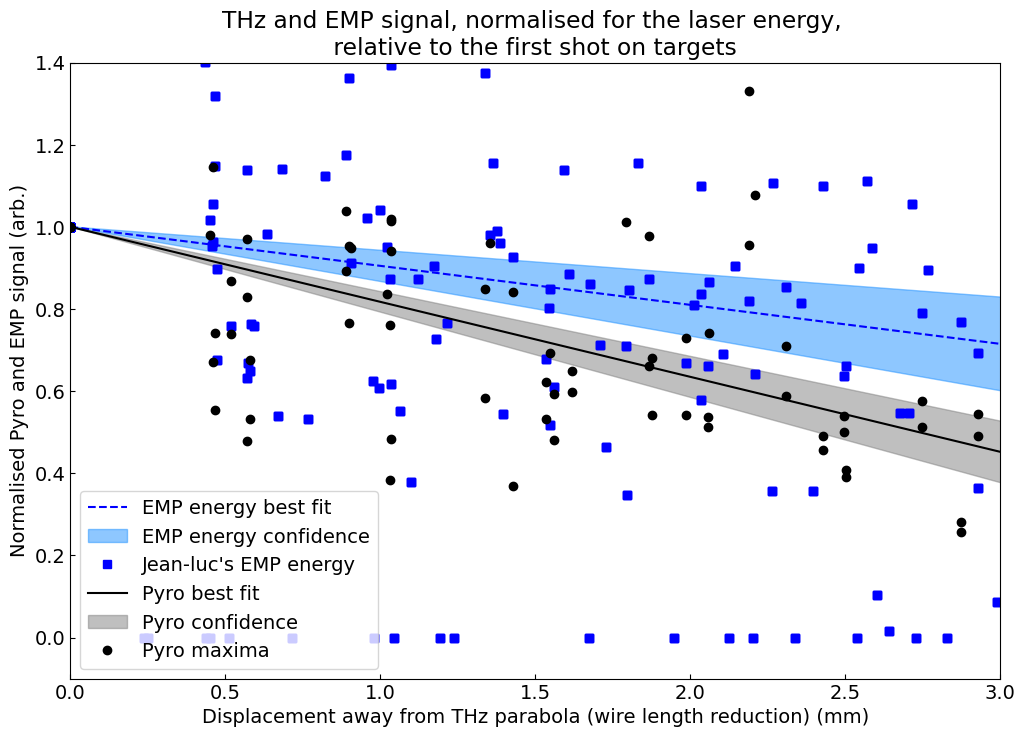

In [54]:
fig, axs = plt.subplots(1, 1, figsize= (12,8))

### PLOT ENERGY
# energy best fit
axs.plot(jeanluc_fit_x,
        jeanluc_fit_y,
        color= "blue",
        linestyle= "--",
        label= "EMP energy best fit")
# energy best fit uncertainty
axs.fill_between(jeanluc_fit_x,
                    jeanluc_fit_delta['lwr_conf'],
                    jeanluc_fit_delta['upr_conf'],
                    color= "dodgerblue",
                    alpha= 0.5,
                    label= "EMP energy confidence")
# energy datapoints
axs.plot(flatten_list([dataset["d"] for ch in plot]),
         # find the corrisponding bdot data unless the pyro data is missing.
        flatten_list([[dataset["energy"][target] for target in range(len(dataset["TARGET NUMBER"]))] for ch in plot]),
        color= "blue",
        linestyle= "None",
        marker= "s",
        label= "Jean-luc's EMP energy")
"""### PLOT BDOT
# bdot best fit
axs.plot(bdot_fit_x,
        bdot_fit_y,
        color= "crimson",
        linestyle= "-.",
        label= "Bdot ptp best fit")
# bdot best fit uncertainty
axs.fill_between(bdot_fit_x,
                    bdot_fit_delta['lwr_conf'],
                    bdot_fit_delta['upr_conf'],
                    color= "red",
                    alpha= 0.5,
                    label= "Bdot ptp confidence")
# bdot datapoints
axs.plot(flatten_3d_list([dataset["d"] for ch in plot]),
         # find the corrisponding bdot data unless the pyro data is missing.
        flatten_3d_list([[dataset["bdot"][target] for target in range(len(dataset["TARGET NUMBER"]))] for ch in plot]),
        color= "red",
        linestyle= "None",
        marker= "^",
        label= "Bdot peak to peak")"""
### PLOT PYRO
# pyro best fit
axs.plot(pyro_fit_x,
        pyro_fit_y,
        color= "k",
        label= "Pyro best fit")
# pyro best fit uncertainty
axs.fill_between(pyro_fit_x,
                pyro_fit_delta['lwr_conf'],
                pyro_fit_delta['upr_conf'],
                color= "gray",
                alpha= 0.5,
                label= "Pyro confidence")
# pyro datapoints
axs.plot(flatten_list([dataset["d"][dataset["TARGET NUMBER"].index(target)] for ch in plot for target in diagnostics[ch]]),
        flatten_list([dataset[ch][dataset["TARGET NUMBER"].index(target)] for ch in plot for target in diagnostics[ch]]),
        color= "k",
        marker = "o",
        linestyle= "None",
        label= "Pyro maxima")

axs.set(xlabel= "Displacement away from THz parabola (wire length reduction) (mm)", # x axis label
        ylabel= "Normalised Pyro and EMP signal (arb.)", # y axis label
        xlim= (0, 3), # x limits
        ylim= (-0.1, 1.4), #y limits
        title= "THz and EMP signal, normalised for the laser energy, \n relative to the first shot on targets ")# + ", ".join(flat_targets.astype(str)) + ".") #title

axs.legend(loc= "lower left") # loc fixes the location of the legend. 

plt.show()